# Imports

In [1]:
import json
import requests
import pandas as pd
from http import HTTPStatus
from matplotlib import pyplot as plt
from typing import Iterable, Dict, Union, List

# Activity 1

## 1.1 Sub-activity: Open Data COVID-19 API

### Task 1

In [2]:
# The code for Task 1 was retrieved from https://coronavirus.data.gov.uk/details/developers-guide/main-api

StructureType = Dict[str, Union[dict, str]]
FiltersType = Iterable[str]
APIResponseType = Union[List[StructureType], str]

def get_API_data(filters:FiltersType , structure: StructureType) -> APIResponseType:
    """
    The function will keep requesting the data from the API until there is no more pages.

    Parameters
    ----------
    filters: FiltersType (dictionary)
        The filters for the API request selecting data from regional or national level.

    structure: StructureType (dictionary)
        The structure for the API request sellecting what kinds of the data that we need.

    Returns
    -------
    APIResponseType: a list of dictionaries
        The data from the API. The dictionary contains the data
        including date, area name, daily cases, cumulative cases, 
        daily deaths, cumulative deaths, cumulative people vaccinated, 
        and vaccination age (a list of dictionaries)
    """
    # API URL
    endpoint = "https://api.coronavirus.data.gov.uk/v1/data"

    api_params = {
        "filters": "areaType=" + filters["areaType"],
        "structure": json.dumps(structure)
    }

    data = []
    page_number = 1
    
    while True:
        # Adding page number to query params
        api_params["page"] = page_number

        response = requests.get(endpoint, params = api_params)

        if response.status_code >= HTTPStatus.BAD_REQUEST:
            raise RuntimeError(f"Request failed: {response.text}")
        elif response.status_code == HTTPStatus.NO_CONTENT:
            break

        current_data = response.json()
        
        # If there is no data in vaccination_age, set the value to None, otherwise the data will be an empty list
        for age in current_data["data"]:
            if not age["vaccination_age"]:
                age["vaccination_age"] = None

        page_data: List[StructureType] = current_data["data"]
       
        data.extend(page_data)

        # The "next" attribute in "pagination" will be `None`
        # when we reach the end.
        if current_data["pagination"]["next"] is None:
            break

        page_number += 1

    return data

### Task 2

In [3]:
# Define the filters and structure
nation_filters = {"areaType": "nation"}
region_filters = {"areaType": "region"}

structure = {
    "date": "date",
    "name": "areaName",
    "daily_cases": "newCasesBySpecimenDate",
    "cumulative_cases": "cumCasesBySpecimenDate",
    "daily_deaths": "newDeaths28DaysByPublishDate",
    "cumulative_deaths": "cumDeaths28DaysByPublishDate",
    "cumulative_vaccinated": "cumPeopleVaccinatedSecondDoseByVaccinationDate",
    "vaccination_age": "vaccinationsAgeDemographics"
}

# Get the data from the API, national and regional level, respectively
results_json_national = get_API_data(nation_filters, structure)
results_json_regional = get_API_data(region_filters, structure)

## 1.2 Sub-activity: Shaping the COVID data into different dataframes

### Task 3

In [4]:
# Concatenate the two lists of dictionaries
covid_data_list = results_json_national + results_json_regional

### Task 4

In [5]:
# Convert the concatenated list of dictionaries to a pandas dataframe
covid_data = pd.DataFrame(covid_data_list)

### Task 5

In [6]:
# Remove the rows with the value "England" in the dataframe
covid_data.drop(covid_data[covid_data["name"] == "England"].index, inplace = True)

### Task 6

In [7]:
# Rename the column "name" to "area"
covid_data.rename(columns={"name": "area"}, inplace=True)

### Task 7

In [8]:
# Convert the type of date column to datetime from string
covid_data["date"] = pd.to_datetime(covid_data["date"])

### Task 8

In [9]:
"""
Since the vaccination_age will return a emtpy list if the 
data isn't available, I set None to the empty age list. 
Therefore, all the None values will be counted as missing 
data in the dataframe
"""
nan = covid_data.isna().sum().sum()
print(covid_data.info())
print("\nThe amount of missing data is {}.".format(nan)) 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12230 entries, 1050 to 13279
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   date                   12230 non-null  datetime64[ns]
 1   area                   12230 non-null  object        
 2   daily_cases            12219 non-null  float64       
 3   cumulative_cases       12217 non-null  float64       
 4   daily_deaths           10243 non-null  float64       
 5   cumulative_deaths      10253 non-null  float64       
 6   cumulative_vaccinated  7369 non-null   float64       
 7   vaccination_age        7276 non-null   object        
dtypes: datetime64[ns](1), float64(5), object(2)
memory usage: 764.5+ KB
None

The amount of missing data is 13803.


### Task 9

In [10]:
# Fill the missing data of each area with the value of the latest date that has values
covid_data["cumulative_cases"] = covid_data.groupby("area")["cumulative_cases"].fillna(method = "bfill")
covid_data["cumulative_deaths"] = covid_data.groupby("area")["cumulative_deaths"].fillna(method = "bfill")
covid_data["cumulative_vaccinated"] = covid_data.groupby("area")["cumulative_vaccinated"].fillna(method = "bfill")

### Task 10

In [11]:
# Drop the rows with missing data of cumulative metrics
covid_data.dropna(subset = ["cumulative_cases", "cumulative_deaths", "cumulative_vaccinated"], inplace=True)

### Task 11

In [12]:
# The code for rolling average was retrieved from https://stackoverflow.com/questions/13996302/python-rolling-functions-for-groupby-object

# Create two new dataframes (7-day rolling average of new daily and death cases in each area)
daily_cases_roll_avg = covid_data.sort_values(["area","date"]).groupby("area")["daily_cases"].rolling(7).mean().reset_index(0, drop = True).rename("daily_cases_roll_avg")
daily_deaths_roll_avg = covid_data.sort_values(["area","date"]).groupby("area")["daily_deaths"].rolling(7).mean().reset_index(0, drop = True).rename("daily_deaths_roll_avg")

# Add the two new columns to the covid_data dataframe
covid_data = pd.concat([covid_data.sort_values(["area","date"]), daily_cases_roll_avg, daily_deaths_roll_avg], axis=1)

### Task 12

In [13]:
# Drop daily_cases and daily_deaths columns
covid_data.drop(columns = ["daily_cases", "daily_deaths"], inplace = True)

### Task 13

In [14]:
# Create a new dataframe with the date, area, vaccination_age columns
covid_data_vaccinations = covid_data.loc[:,["date","area","vaccination_age"]]

# Drop the vaccination_age from the covid_data dataframe
covid_data.drop(columns = ["vaccination_age"], inplace = True)

### Task 14

In [15]:
# Explode the dictionaries that are inside of the vaccination_age list for each row
exploded = covid_data_vaccinations.explode("vaccination_age", ignore_index = True)

# Since the dictionaries are exploded and the dictionaries are in JSON format, 
# then use the json_normalize function to convert the dictionaries to columns
normalized = pd.json_normalize(exploded["vaccination_age"])

# Concatenate the exploded and normalized dataframes
covid_data_vaccinations_wide = pd.concat([exploded, normalized], axis = 1)

# Drop redundant columns
covid_data_vaccinations_wide.drop(columns = [
    "vaccination_age",
    "cumPeopleVaccinatedThirdInjectionByVaccinationDate",
    "newPeopleVaccinatedThirdInjectionByVaccinationDate",
    "cumVaccinationThirdInjectionUptakeByVaccinationDatePercentage",
    "cumPeopleVaccinatedAutumn22ByVaccinationDate",
    "cumPeopleVaccinatedSpring22ByVaccinationDate",
    "newPeopleVaccinatedAutumn22ByVaccinationDate",
    "newPeopleVaccinatedSpring22ByVaccinationDate",
    "cumVaccinationAutumn22UptakeByVaccinationDatePercentage",
    "cumVaccinationSpring22UptakeByVaccinationDatePercentage"
    ], inplace = True)

## 1.3 Sub-activity: Aggregating, plotting, and analysing

### Handling missing data before the 1.3 Sub-activity starts

In [16]:
"""
Areas except Northern Ireland and Scotland 
have the data of 2022/12/08 (latest date).

Since the Northern Ireland missed data from 
2022/5/20 to 2022/12/08, and the Scotland missed 
data from 2022/12/04 to 2022/12/08, we need to add 
more data to the Northern Ireland from 2022/5/20 to 
2022/12/8 and to the Scotland from 2022/12/04 to 2022/12/8

The way I fill the missing data is to fill the missing data 
with the value of the latest date that has values
"""

def filling_missing_data(covid_data, area_name):
    """
    This function is to fill the missing data with the value of the latest date that has values.

    Parameters
    ----------
    covid_data : pandas dataframe
        The dataframe that contains the data retrieved from the API.
    
    area_name : string

    Returns
    -------
    covid_data_with_new_data: pandas dataframe
        The dataframe that is filled with new data.
    """

    # Get the latest date of the area that has values
    # Since London and other areas, say Wales or North East, 
    # will update the latest data ocationally, 
    # I use the latest date of London to be the latest date to fill the missing data.
    fill_to_date = covid_data[covid_data["area"] == "London"]["date"].tail(1).values[0]

    # Get the date that started to miss data
    fill_from_date = covid_data[covid_data["area"] == area_name]["date"].tail(1).values[0]

    # Get the data of the area that has missing data
    area_data = covid_data[covid_data["area"] == area_name]

    # Create a new dataframe with the date range from the date that started to miss data to the latest date
    date_range = pd.DataFrame(pd.date_range(start = fill_from_date, end = fill_to_date), columns = ["date"])

    # Outer join the date_range dataframe to the area dataframe
    area_with_empty_cell = pd.merge(area_data, date_range, how = "outer", on = "date")

    # Fill the missing data with the value of the latest date that has values
    area_with_new_data = area_with_empty_cell.ffill()

    # Drop the oringinal data of the area that has missing data
    covid_data_drop_old_data = covid_data[covid_data["area"] != area_name]

    # Add back area with new date to the covid_data dataframe
    covid_data_with_new_data = pd.concat([covid_data_drop_old_data, area_with_new_data])

    return covid_data_with_new_data

In [17]:
# Fill the missing data for Northern Ireland and Scotland
Northern_Ireland_new_data = filling_missing_data(covid_data, "Northern Ireland")
covid_data_with_new_data = filling_missing_data(Northern_Ireland_new_data, "Scotland")

# Replace the covid_data by covid_data with the new data
covid_data = covid_data_with_new_data

# There are some areas that have duplicated data, so drop the duplicated data
covid_data.drop_duplicates(subset = ["date", "area"], inplace = True)

### Task 15

' \n3.0 Answer to Task 15\n\nWe can see from the plot that the cumulative cases in London \nhas been increasing since the end of December 2020, while\nthere are two plateaus in the plot. The first plateau is from\nthe beginning of February 2021 to the beginning of July 2021, and \nthe second plateau is from the beginning of April to the end of \nthe year (slightly increased). \n'

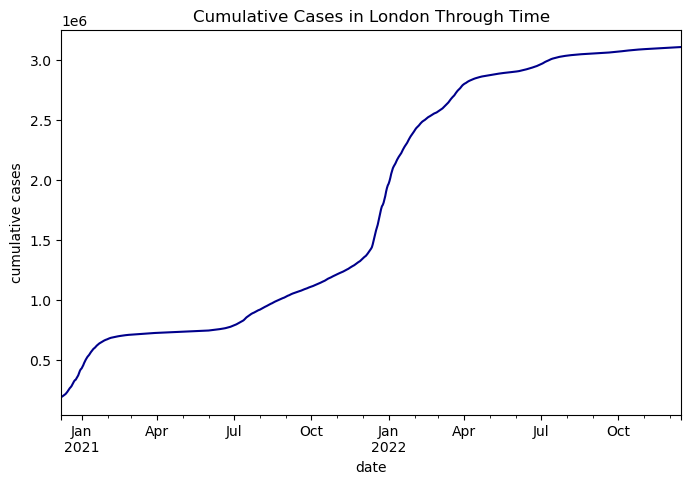

In [18]:
# 1.0 Intermediate dataframe
# Group the data by date and sum the cumulative cases in London
cumulative_cases_in_London_through_time = covid_data[covid_data["area"] == "London"].groupby("date")["cumulative_cases"].sum()

# 2.0 Plot to intermediate dataframe
cumulative_cases_in_London_through_time.plot(x = "date", y = "cumulative_cases", figsize = (8,5), ylabel = "cumulative cases", title = "Cumulative Cases in London Through Time", color = "darkblue")

""" 
3.0 Answer to Task 15

We can see from the plot that the cumulative cases in London 
has been increasing since the end of December 2020, while
there are two plateaus in the plot. The first plateau is from
the beginning of February 2021 to the beginning of July 2021, and 
the second plateau is from the beginning of April to the end of 
the year (slightly increased). 
"""

### Task 16

'\n3.0 Answer to Task 16\n\nWe can see from the plot that the cumulative cases in all areas\nis almost the same as the cumulative cases in London. Additionally, \nduring December 2020 and January 2021 the cumulative cases of London \nincreased rapidly than that in all areas, whereas from July 2021 to \nJanuary 2022 the slope of the cumulative cases in all areas is higher \nthan that in London.\n'

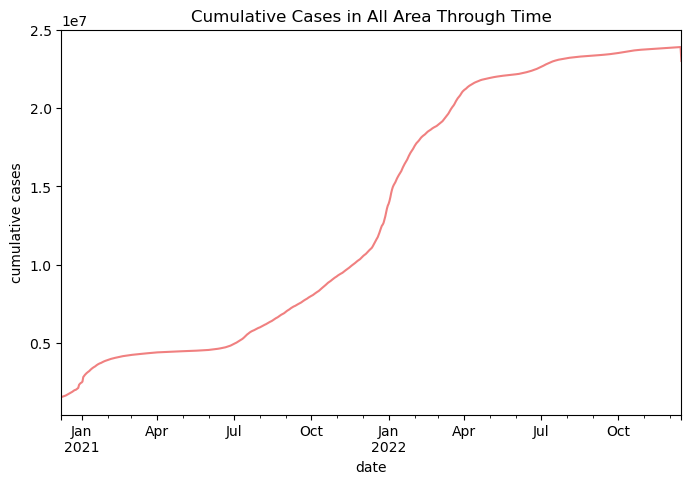

In [19]:
# 1.0 Intermediate dataframe
# Group the data by date and sum the cumulative cases in all areas
cumulative_cases_summed_over_all_areas = covid_data.groupby("date")["cumulative_cases"].sum()

# 2.0 Plot to intermediate dataframe
cumulative_cases_summed_over_all_areas.plot(figsize = (8,5), ylabel = "cumulative cases", title = "Cumulative Cases in All Area Through Time", color = "lightcoral")

"""
3.0 Answer to Task 16

We can see from the plot that the cumulative cases in all areas
is almost the same as the cumulative cases in London. Additionally, 
during December 2020 and January 2021 the cumulative cases of London 
increased rapidly than that in all areas, whereas from July 2021 to 
January 2022 the slope of the cumulative cases in all areas is higher 
than that in London.
"""

### Task 17

'\n3.0 Answer to Task 17\n\nWe can see from the plot that a pattern that all nations \nand regions shares is that the cumulative cases in all areas \nincreased slowly since the beginning of January 2021, and then \nincreased rapidly from the beginning of July 2021 to the end of \nApril 2022, after which the cumulative cases increased slowly \nand then plateaud to the end of the year.\n'

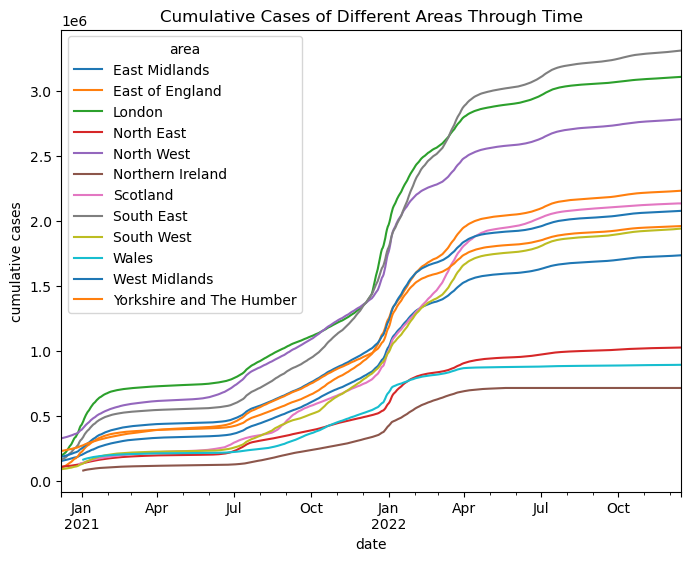

In [20]:
# 1.0 Intermediate dataframe
# Group the data by date and area and sum the cumulative cases over all areas, respectively
cumulative_cases_of_different_areas = covid_data.groupby(["date","area"])["cumulative_cases"].sum().unstack()

# 2.0 Plot to intermediate dataframe
cumulative_cases_of_different_areas.plot(figsize=(8, 6), title = "Cumulative Cases of Different Areas Through Time", ylabel = "cumulative cases", xlabel = "date")

"""
3.0 Answer to Task 17

We can see from the plot that a pattern that all nations 
and regions shares is that the cumulative cases in all areas 
increased slowly since the beginning of January 2021, and then 
increased rapidly from the beginning of July 2021 to the end of 
April 2022, after which the cumulative cases increased slowly 
and then plateaud to the end of the year.
"""

### Task 18

In [21]:
"""
Answer to Task 18

There are two possible events that could cause the trend in June-July 2021. 

Firstly, this happened might be because of the new covid variant. 

Secondly, the restriction of covid lockdown was lifted  on 19 July 2021, 
which could lead to the trend that is a constant increase in the cumulative cases.
"""

'\nAnswer to Task 18\n\nThere are two possible events that could cause the trend in June-July 2021. \n\nFirstly, this happened might be because of the new covid variant. \n\nSecondly, the restriction of covid lockdown was lifted  on 19 July 2021, \nwhich could lead to the trend that is a constant increase in the cumulative cases.\n'

### Task 19

'\n3.0 Answer to Task 19\n\nYes, there was a noticeable period that broke the ongoing trend of the \ncumulative deaths in London. It was around at the beginning of March 2021.\n'

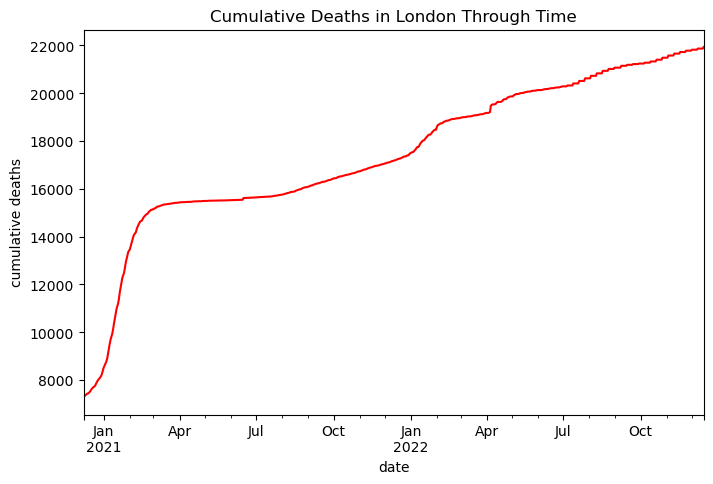

In [22]:
# 1.0 Intermediate dataframe
# Group the data by date and sum the cumulative deaths in London
cumulative_deaths_in_London = covid_data[covid_data["area"] == "London"].groupby("date")["cumulative_deaths"].sum()

# 2.0 Plot to intermediate dataframe
cumulative_deaths_in_London.plot(title = "Cumulative Deaths in London Through Time", ylabel = "cumulative deaths", figsize = (8,5), color = "red")

"""
3.0 Answer to Task 19

Yes, there was a noticeable period that broke the ongoing trend of the 
cumulative deaths in London. It was around at the beginning of March 2021.
"""

### Task 20

In [23]:
"""
Answer to Task 20

There are three similarites between the cumulative cases and the cumulative deaths in London.

Firstly, the cumulative cases and the cumulative deaths in London increased rapidly from the 
beginning of December 2020 to the end of January.

Secondly, the cumulative cases and the cumulative deaths in London started to increase slowly 
from the beginning of March 2021 to the beginning of July 2021. 
"""

'\nAnswer to Task 20\n\nThere are three similarites between the cumulative cases and the cumulative deaths in London.\n\nFirstly, the cumulative cases and the cumulative deaths in London increased rapidly from the \nbeginning of December 2020 to the end of January.\n\nSecondly, the cumulative cases and the cumulative deaths in London started to increase slowly \nfrom the beginning of March 2021 to the beginning of July 2021. \n'

### Task 21

'\n3.0 Answer to Task 21\n\nOverall, there was a downward trend in the cumulative deaths per cases \nfrom the December 2020 to the end of 2022. \n'

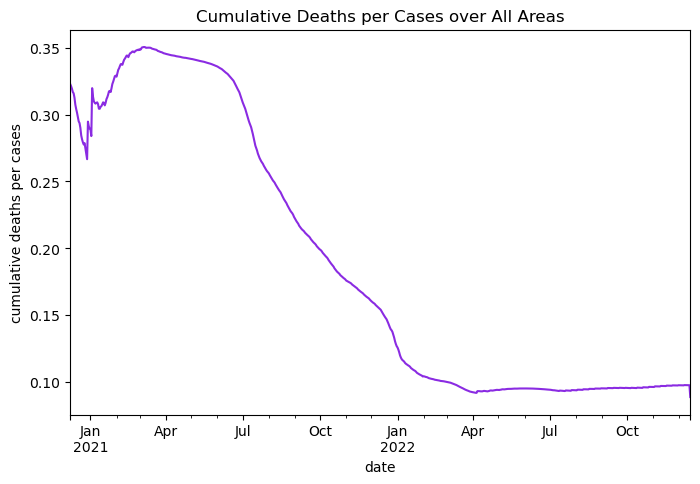

In [24]:
# Create a new column called cumulative_deaths_per_cases in covid_data 
# which is the result of cumulative deaths / cumulative cases
covid_data["cumulative_deaths_per_cases"] = covid_data["cumulative_deaths"] / covid_data["cumulative_cases"]

# 1.0 Intermediate dataframe
# Group the data by date and sum the cumulative deaths per cases over all areas
cumulative_deaths_per_cases = covid_data.groupby("date")["cumulative_deaths_per_cases"].sum()

# 2.0 Plot to intermediate dataframe
cumulative_deaths_per_cases.plot(title = "Cumulative Deaths per Cases over All Areas", ylabel = "cumulative deaths per cases", figsize = (8,5), color = "blueviolet")

"""
3.0 Answer to Task 21

Overall, there was a downward trend in the cumulative deaths per cases 
from the December 2020 to the end of 2022. 
"""

### Task 22

In [25]:
"""
Answer to Task 22

One reasonable reason for the inclination gets steeper in June-July 
could be people were getting vaccinated at that time.
"""

'\nAnswer to Task 22\n\nOne reasonable reason for the inclination gets steeper in June-July \ncould be people were getting vaccinated at that time.\n'

### Task 23

"\nAnswer to Task 23\n\nOne possible relationship between Task 23 and Task 21's plot is that \nafter more and more people were vaccinated, the cumulative deaths per cases decreased, which\nmeans that the vaccination could be effective in reducing the deaths and the situation of the\ncovid-19 was under control.\n"

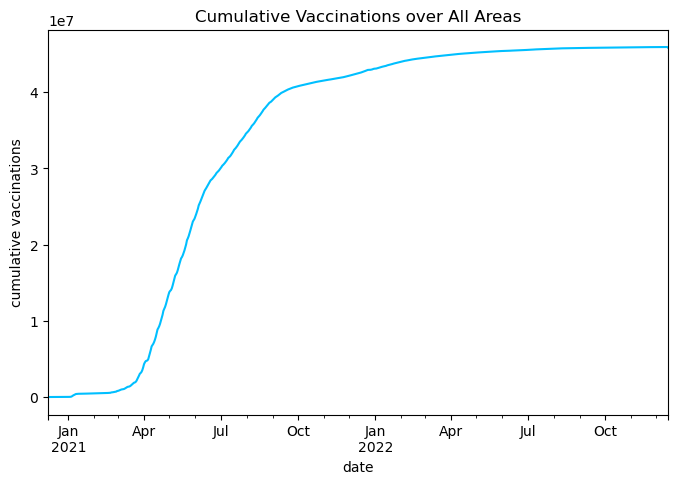

In [26]:
# 1.0 Intermediate dataframe
# Group the data by date and sum the cumulative vaccinations over all areas
cumulative_vaccinations_over_all_areas = covid_data.groupby("date")["cumulative_vaccinated"].sum()

# 2.0 Plot to intermediate dataframe
cumulative_vaccinations_over_all_areas.plot(title = "Cumulative Vaccinations over All Areas", ylabel = "cumulative vaccinations", figsize = (8,5), color = "deepskyblue")

"""
Answer to Task 23

One possible relationship between Task 23 and Task 21's plot is that 
after more and more people were vaccinated, the cumulative deaths per cases decreased, which
means that the vaccination could be effective in reducing the deaths and the situation of the
covid-19 was under control.
"""

### Task 24

'\nAnswer to Task 24\n\nThe general trend of the daily cases rolling average is that the daily cases rolling average obviously\npeaked around January 2021, mid of July 2021, mid of October 2021, January 2022, mid of April 2022, \nbeginning of July 2022, and beginning of October 2022. There are four areas that seem to escape the \ngeneral trend of the daily cases rolling average, namely Northern Ireland, North East, Wales, and Scotland.\n\nOverall, the daily cases rolling average in these did not peak as much as the other areas\nin the beginning of January 2021. From July 2021 to December 2021, the daily cases rolling average\nwas more flat than the other areas.\n\nHowever, the daily cases rolling average in Scotland almost followed the general trend of the daily cases.\nThis is because there was a peak in September 2021 which was prior to the peaks in the other areas in the \nmid of October 2021. As a result, the daily cases rolling average in Scotland could be considered to be \none o

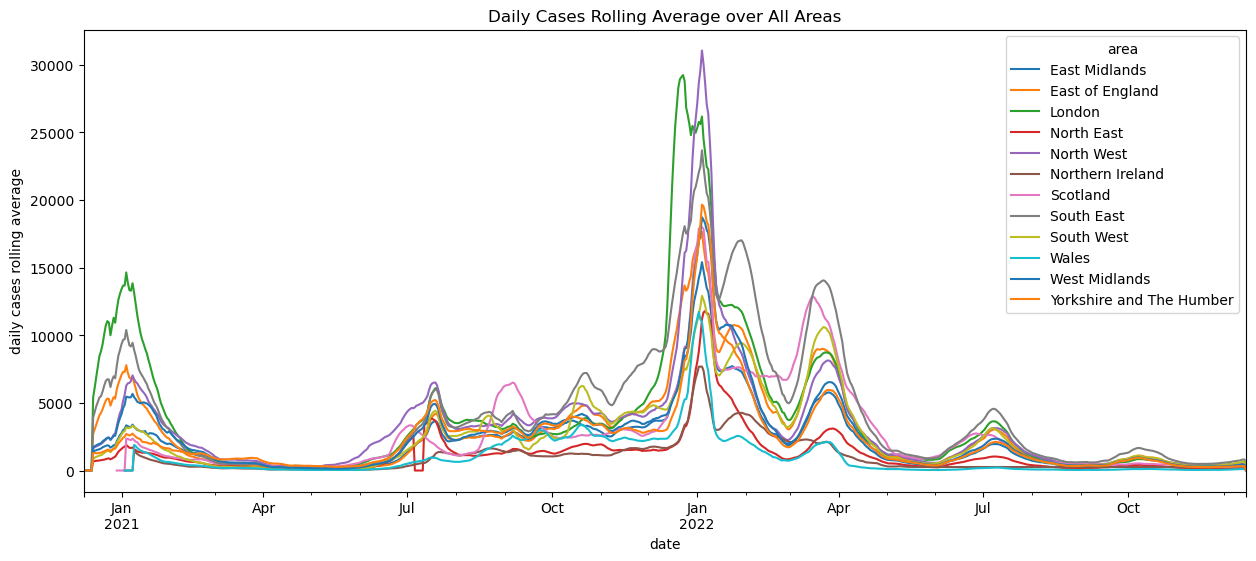

In [27]:
# 1.0 Intermediate dataframe
# Group the data by date and sum the cumulative vaccinations over all areas, respectively
daily_cases_rolling_average_separated_by_areas = covid_data.groupby(["date","area"])["daily_cases_roll_avg"].sum().unstack()

# 2.0 Plot to intermediate dataframe
daily_cases_rolling_average_separated_by_areas.plot(figsize=(15, 6), title = "Daily Cases Rolling Average over All Areas", ylabel = "daily cases rolling average", xlabel = "date")

"""
Answer to Task 24

The general trend of the daily cases rolling average is that the daily cases rolling average obviously
peaked around January 2021, mid of July 2021, mid of October 2021, January 2022, mid of April 2022, 
beginning of July 2022, and beginning of October 2022. There are four areas that seem to escape the 
general trend of the daily cases rolling average, namely Northern Ireland, North East, Wales, and Scotland.

Overall, the daily cases rolling average in these did not peak as much as the other areas
in the beginning of January 2021. From July 2021 to December 2021, the daily cases rolling average
was more flat than the other areas.

However, the daily cases rolling average in Scotland almost followed the general trend of the daily cases.
This is because there was a peak in September 2021 which was prior to the peaks in the other areas in the 
mid of October 2021. As a result, the daily cases rolling average in Scotland could be considered to be 
one of the areas that seems to escape the general trend.
"""

### Task 25

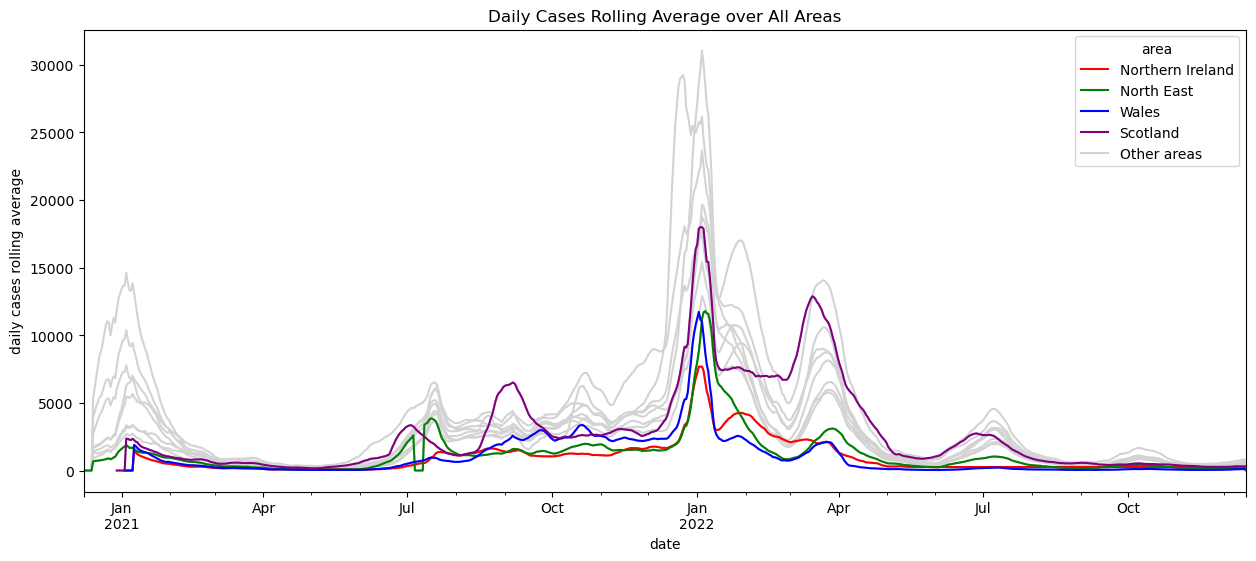

'\nAnswer to Task 25\n\nThere are two factors comtributing to the difference between the daily cases rolling average, \nnamely geographical location and population density.\n\nFirstly, the geographical location of Northern Ireland, North East, Wales, and Scotland are far away\nfrom the center of the covid-19 outbreak, which is around London. As a result, the daily cases rolling average\nwould be less affected by the covid-19 outbreak.\n\nSecondly, the population density of Northern Ireland, North East, Wales, and Scotland are way lower than\nthe population density of other areas, 1,895,510, 2,669,941, 3,169,586, 5,466,000 by the year of 2020, respectively \n(data retrived from https://en.wikipedia.org/wiki/Regions_of_England and \nhttps://en.wikipedia.org/wiki/Demography_of_the_United_Kingdom). \nAs a result, the chance that people would be infected by the covid-19 is lower than the other areas.\n\nAdditionally, since the population density of Scotland is the highest among the four are

In [28]:
# 1.0 Intermediate dataframe
# Group the data by date and sum the daily cases rolling average in Northern Ireland, North East, Wales, and Scotland
daily_cases_rolling_average_Northern_Ireland = covid_data[covid_data["area"] == "Northern Ireland"].groupby(["date"])["daily_cases_roll_avg"].sum()
daily_cases_rolling_average_North_East = covid_data[covid_data["area"] == "North East"].groupby(["date"])["daily_cases_roll_avg"].sum()
daily_cases_rolling_average_Wales = covid_data[covid_data["area"] == "Wales"].groupby(["date"])["daily_cases_roll_avg"].sum()
daily_cases_rolling_average_Scotland = covid_data[covid_data["area"] == "Scotland"].groupby(["date"])["daily_cases_roll_avg"].sum()

# 2.0 Plot to intermediate dataframe
# Set the figure size
fig = plt.figure(figsize=(15, 6))
# Set the subplot
ax = fig.add_subplot(111)
# Plot the graph in the subplot
daily_cases_rolling_average_separated_by_areas.plot(ax=ax, color = "lightgrey")
daily_cases_rolling_average_Northern_Ireland.plot(ax=ax, color = "red")
daily_cases_rolling_average_North_East.plot(ax=ax, color = "green")
daily_cases_rolling_average_Wales.plot(ax=ax, color = "blue")
daily_cases_rolling_average_Scotland.plot(ax=ax, color = "purple")
# Add title to the plot
plt.title("Daily Cases Rolling Average over All Areas")
# Add y label to the plot
plt.ylabel("daily cases rolling average")
# The code thet can set legend colors was retrieved from https://stackoverflow.com/questions/23698850/manually-set-color-of-points-in-legend
# Change the legends' names and colors
plt.legend(["Northern Ireland", "North East", "Wales", "Scotland", "Other areas"], title = "area")
ax.get_legend().legendHandles[0].set_color("red")
ax.get_legend().legendHandles[1].set_color("green")
ax.get_legend().legendHandles[2].set_color("blue")
ax.get_legend().legendHandles[3].set_color("purple")
ax.get_legend().legendHandles[4].set_color("lightgrey")
# Show the plot
plt.show()

"""
Answer to Task 25

There are two factors comtributing to the difference between the daily cases rolling average, 
namely geographical location and population density.

Firstly, the geographical location of Northern Ireland, North East, Wales, and Scotland are far away
from the center of the covid-19 outbreak, which is around London. As a result, the daily cases rolling average
would be less affected by the covid-19 outbreak.

Secondly, the population density of Northern Ireland, North East, Wales, and Scotland are way lower than
the population density of other areas, 1,895,510, 2,669,941, 3,169,586, 5,466,000 by the year of 2020, respectively 
(data retrived from https://en.wikipedia.org/wiki/Regions_of_England and 
https://en.wikipedia.org/wiki/Demography_of_the_United_Kingdom). 
As a result, the chance that people would be infected by the covid-19 is lower than the other areas.

Additionally, since the population density of Scotland is the highest among the four areas, this could be a 
reason why the daily cases rolling average in Scotland is the closest to the general trend of the daily cases.
"""


### Task 26

'\nAnswer to Task 26\n\nYes, there are some parts that the daily trends of cases and deaths increasing and decreasing \nat the same rates.\n\nThe parts are: after around April 2022. Even though there was time shift between the two lines \n(it is reasonable since people catch covid-19 first and would probably die later, no offense).\n\nAs a result, by ignornig the time shift, the rates of daily trends of cases and deaths \nincreasing and decreasing are matched, in general.\n'

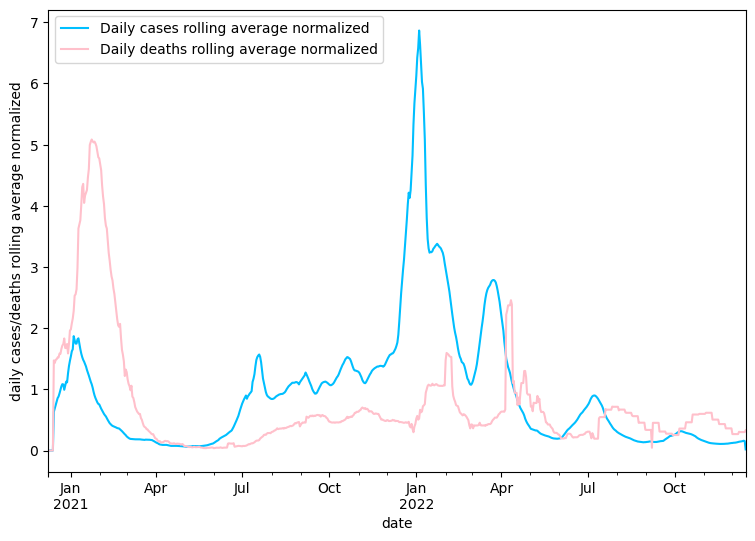

In [29]:
# Create two new columns called "daily_cases_roll_avg_norm" 
# and "daily_deaths_roll_avg_norm" that are divided by the 
# maximum value of the column
covid_data["daily_cases_roll_avg_norm"] = covid_data["daily_cases_roll_avg"] / covid_data["daily_cases_roll_avg"].max()
covid_data["daily_deaths_roll_avg_norm"] = covid_data["daily_deaths_roll_avg"] / covid_data["daily_deaths_roll_avg"].max()

# 1.0 Intermediate dataframe
# Group the data by date and sum the daily cases rolling average normalized
daily_cases_roll_avg_norm = covid_data.groupby("date")["daily_cases_roll_avg_norm"].sum()
# Group the data by date and sum the daily deaths rolling average normalized
daily_deaths_roll_avg_norm = covid_data.groupby("date")["daily_deaths_roll_avg_norm"].sum()


# 2.0 Plot to intermediate dataframe
daily_cases_roll_avg_norm.plot(figsize = (9, 6), color = "deepskyblue")
daily_deaths_roll_avg_norm.plot(figsize = (9, 6), color = "pink")
# Add legend to the plot
plt.legend(["Daily cases rolling average normalized", "Daily deaths rolling average normalized"])
# Add the y label to the plot
plt.ylabel("daily cases/deaths rolling average normalized")

"""
Answer to Task 26

Yes, there are some parts that the daily trends of cases and deaths increasing and decreasing 
at the same rates.

The parts are: after around April 2022. Even though there was time shift between the two lines 
(it is reasonable since people catch covid-19 first and would probably die later, no offense).

As a result, by ignornig the time shift, the rates of daily trends of cases and deaths 
increasing and decreasing are matched, in general.
"""

### Task 27

"\nAnswer to Task 27\n\nAll the age groups in London were not vaccinated at the same time.\n\nThere is a strategy that was used to vaccinate the London's population.\n\nThe strategy is to vaccinate the population in age order, starting with \nthe oldest age group and working down to the youngest age group. This might \nbe because the older age group are more vulnerable. Poeple who are older than \n50 were entirely opened to be vaccinated at the beginning, whereas poeple who \nare in 18-49 age group were not entirely opened to be vaccinated at the beginning. \nThis could be because in this age group, people who have serious medical conditions \nneeded to be vaccinated first, and then the vaccination was entirely opened to the rest of the \npeople in this age group. After people who are older than 18 were vaccinated, the people \nwho are younger than 18 started to be vaccinated. This could be because the younger age group\nare less vulnerable to the covid-19.\n"

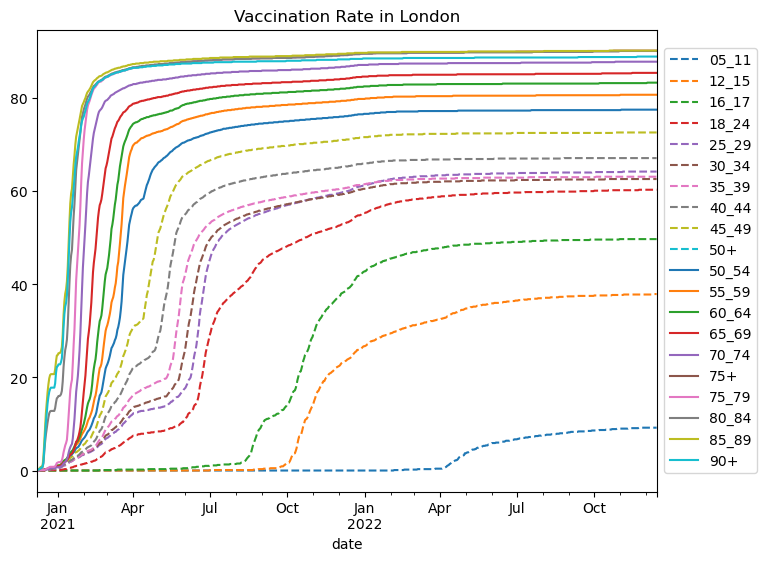

In [30]:
# Split the data of covid_data_vaccinations_wide into London and Scotland
covid_data_vaccinations_wide_london = covid_data_vaccinations_wide[covid_data_vaccinations_wide["area"] == "London"]
covid_data_vaccinations_wide_scotland = covid_data_vaccinations_wide[covid_data_vaccinations_wide["area"] == "Scotland"]

# 1.0 Intermediate dataframe
# Create a new dataframe for London that has the date, age, and cumVaccinationFirstDoseUptakeByVaccinationDatePercentage
covid_data_vaccinations_wide_london = covid_data_vaccinations_wide_london[["date", "age", "cumVaccinationFirstDoseUptakeByVaccinationDatePercentage"]]
# Get the column names
columns = covid_data_vaccinations_wide_london.groupby('date')['age'].apply(list)[0]
# Group the data by date and get the cumVaccinationFirstDoseUptakeByVaccinationDatePercentage
covid_data_vaccinations_wide_london = covid_data_vaccinations_wide_london.groupby('date')['cumVaccinationFirstDoseUptakeByVaccinationDatePercentage'].apply(list).apply(pd.Series)
# Rename the columns
covid_data_vaccinations_wide_london.columns = columns
# Reset the index
covid_data_vaccinations_wide_london.reset_index(inplace = True)

# 2.0 Plot to intermediate dataframe
covid_data_vaccinations_wide_london.plot(figsize = (8, 6), title = "Vaccination Rate in London",  x = "date", y = columns, style = ["--" for _ in range(10)])
# The code thet can set legend location was retrieved from https://stackoverflow.com/questions/40908983/arguments-of-bbox-to-anchor-function
plt.legend(loc = "center left", bbox_to_anchor = (1, 0.5))

"""
Answer to Task 27

All the age groups in London were not vaccinated at the same time.

There is a strategy that was used to vaccinate the London's population.

The strategy is to vaccinate the population in age order, starting with 
the oldest age group and working down to the youngest age group. This might 
be because the older age group are more vulnerable. Poeple who are older than 
50 were entirely opened to be vaccinated at the beginning, whereas poeple who 
are in 18-49 age group were not entirely opened to be vaccinated at the beginning. 
This could be because in this age group, people who have serious medical conditions 
needed to be vaccinated first, and then the vaccination was entirely opened to the rest of the 
people in this age group. After people who are older than 18 were vaccinated, the people 
who are younger than 18 started to be vaccinated. This could be because the younger age group
are less vulnerable to the covid-19.
"""

### Task 28

"\nAnswer to Task 28\n\nOverall, based on the two plots, London and Scotland took the same strategy to vaccinate their population.\nLondon's age cut-off was smaller than Scotland's age cut-off.\nLondon seemed to prioritise the 75-79, 70-74, 65-69, 60-64, 55-59, and 50-54 age groups first, \nwhereas Scotland seemed to prioritise 50-64 and 65-79 age groups.\n"

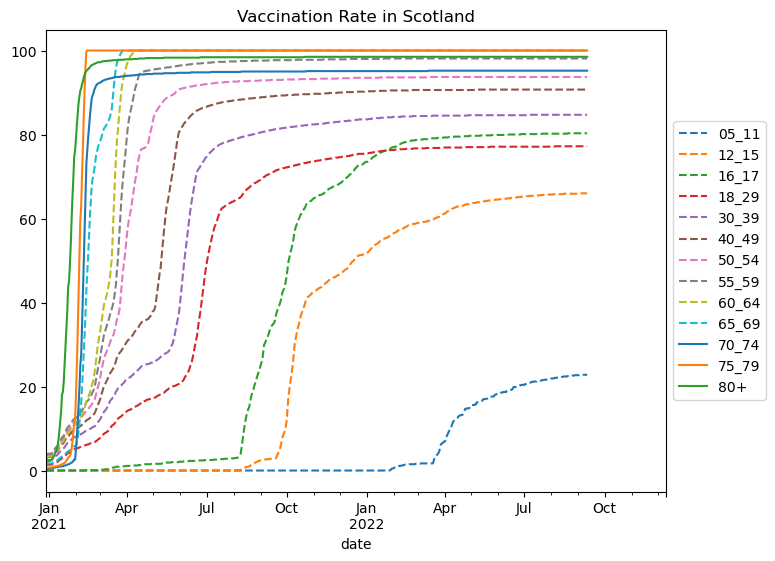

In [31]:
# 1.0 Intermediate dataframe
# Create a new dataframe for Scotland that has the date, age, and cumVaccinationFirstDoseUptakeByVaccinationDatePercentage
covid_data_vaccinations_wide_scotland = covid_data_vaccinations_wide_scotland[["date", "age", "cumVaccinationFirstDoseUptakeByVaccinationDatePercentage"]]
# Get the column names
columns = covid_data_vaccinations_wide_scotland.groupby('date')['age'].apply(list)[0]
# Group the data by date and get the cumVaccinationFirstDoseUptakeByVaccinationDatePercentage
covid_data_vaccinations_wide_scotland = covid_data_vaccinations_wide_scotland.groupby('date')['cumVaccinationFirstDoseUptakeByVaccinationDatePercentage'].apply(list).apply(pd.Series)
# Rename the columns
covid_data_vaccinations_wide_scotland.columns = columns
# Reset the index
covid_data_vaccinations_wide_scotland.reset_index(inplace=True)

# 2.0 Plot to intermediate dataframe
covid_data_vaccinations_wide_scotland.plot(figsize = (8, 6), title = "Vaccination Rate in Scotland", x = "date", y = columns, style = ["--" for _ in range(10)])
# The code thet can set legend location was retrieved from https://stackoverflow.com/questions/40908983/arguments-of-bbox-to-anchor-function
plt.legend(loc = 'center left', bbox_to_anchor = (1, 0.5))

"""
Answer to Task 28

Overall, based on the two plots, London and Scotland took the same strategy to vaccinate their population.
London's age cut-off was smaller than Scotland's age cut-off.
London seemed to prioritise the 75-79, 70-74, 65-69, 60-64, 55-59, and 50-54 age groups first, 
whereas Scotland seemed to prioritise 50-64 and 65-79 age groups.
"""